# Notebook 20250116

This code is for RNA structure analysis

Requirement:

- MDtraj
- DeepTime
- NumPy, Matplotlib, SciPy

This script is able to:

- Get C1' coordinates
- Calculate RMSD matrix
- Hierarchical Clustering using RMSD matrix
- Get tICA for coordinates or pairwise distance

In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from deeptime.decomposition import TICA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

mpl.rcParams["font.size"] = 12
mpl.rcParams["font.family"] = "Arial"

In [2]:
# Step 1: Load md trajectories
# For SYSTEM 1 (test_1)
traj_origin_rep1 = md.load("traj/system_1_origin_rep1.pdb")
traj_origin_rep2 = md.load("traj/system_1_origin_rep2.pdb")
traj_origin_rep3 = md.load("traj/system_1_origin_rep3.pdb")
traj_modified_rep1 = md.load("traj/system_1_fixed_rep1.pdb")
traj_modified_rep2 = md.load("traj/system_1_fixed_rep2.pdb")
traj_modified_rep3 = md.load("traj/system_1_fixed_rep3.pdb")


In [3]:
# merge all trajectories
traj_merged = md.join([traj_origin_rep1, traj_origin_rep2, traj_origin_rep3,
                       traj_modified_rep1, traj_modified_rep2, traj_modified_rep3])

source_merged = np.concatenate([np.zeros(len(traj_origin_rep1), dtype=int),
                                np.zeros(len(traj_origin_rep2), dtype=int),
                                np.zeros(len(traj_origin_rep3), dtype=int),
                                np.ones(len(traj_modified_rep1), dtype=int),
                                np.ones(len(traj_modified_rep2), dtype=int),
                                np.ones(len(traj_modified_rep3), dtype=int)])

In [4]:
# get C1' atom_indices
atom_indices = []

for atom in traj_merged.topology.atoms:
    if atom.name == "C1'":
        atom_indices.append(atom.index)

# calculate RMSD matrix
def calc_rmsd_matrix(traj, atom_indices=None):
    n_frames = traj.n_frames
    rmsd_matrix = np.zeros((n_frames, n_frames))
    for i in range(n_frames):
        if atom_indices is None:
            rmsd_matrix[i] = md.rmsd(traj, traj, i)
        else:
            rmsd_matrix[i] = md.rmsd(traj, traj, i, atom_indices=atom_indices)
    return rmsd_matrix


rmsd_matrix = calc_rmsd_matrix(traj_merged, atom_indices=atom_indices)

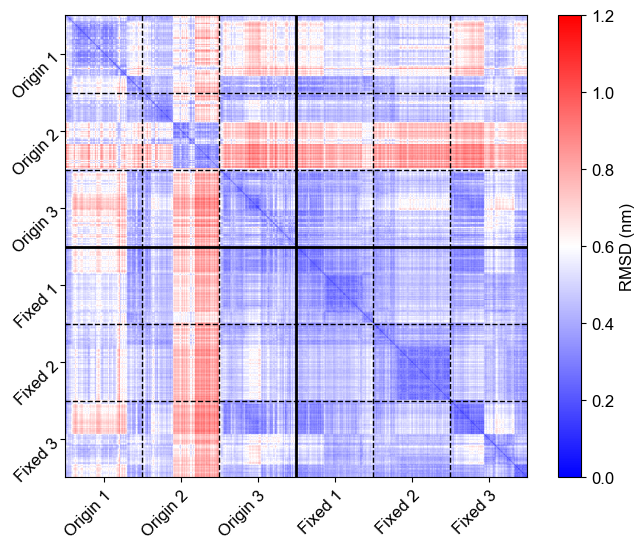

In [5]:
plt.figure(figsize=(8, 6))

plt.imshow(rmsd_matrix, vmin=0, vmax=1.2, cmap="bwr")

for i in [1,2,4,5]:
    plt.axvline(i * len(traj_origin_rep1), color="k", linestyle="--", linewidth=1)
    plt.axhline(i * len(traj_origin_rep1), color="k", linestyle="--", linewidth=1)
plt.axvline(3*len(traj_origin_rep1), color="k", linestyle="-", linewidth=2)
plt.axhline(3*len(traj_origin_rep1), color="k", linestyle="-", linewidth=2)

plt.colorbar(label="RMSD (nm)")

n_frames_block = len(traj_origin_rep1)
plt.xticks(np.arange(n_frames_block/2, 6*n_frames_block, n_frames_block), 
           ["Origin 1", "Origin 2", "Origin 3", "Fixed 1", "Fixed 2", "Fixed 3"],
           rotation=45, rotation_mode="anchor", ha="right")

plt.yticks(np.arange(n_frames_block/2, 6*n_frames_block, n_frames_block),
              ["Origin 1", "Origin 2", "Origin 3", "Fixed 1", "Fixed 2", "Fixed 3"],
                rotation=45, rotation_mode="anchor", ha="right")

plt.savefig("figure/system_1_rmsd_matrix.png", dpi=300, bbox_inches="tight")

In [6]:
# ensure the symmetry of the rmsd matrix
rmsd_matrix = (rmsd_matrix + rmsd_matrix.T) / 2
# set trace to zero
np.fill_diagonal(rmsd_matrix, 0)


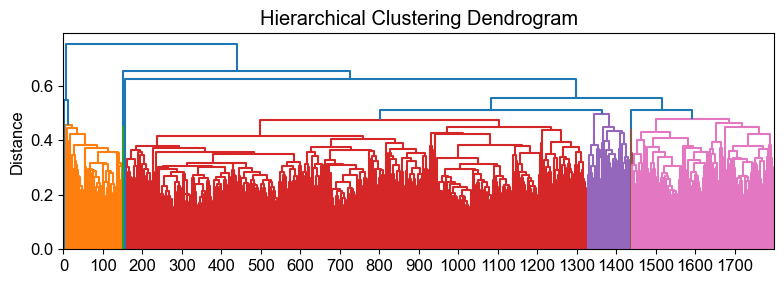

8


In [7]:
DISTANCE_THRESHOLD = 0.5

distance_matrix = squareform(rmsd_matrix)
linkage_matrix = linkage(distance_matrix, method='average')
hierarchal_cluster = fcluster(linkage_matrix, DISTANCE_THRESHOLD, criterion='distance')



# create a dendrogram, but not show it
plt.figure(figsize=(8, 3))
tree_dict = dendrogram(linkage_matrix, color_threshold=DISTANCE_THRESHOLD, no_labels=True)


plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.xticks(np.arange(0, len(traj_merged)*10, 1000), np.arange(0, len(traj_merged), 100))
plt.tight_layout()
plt.show()

print(len(set(hierarchal_cluster)))
cluster_id_list = np.arange(1,1+len(set(hierarchal_cluster)))


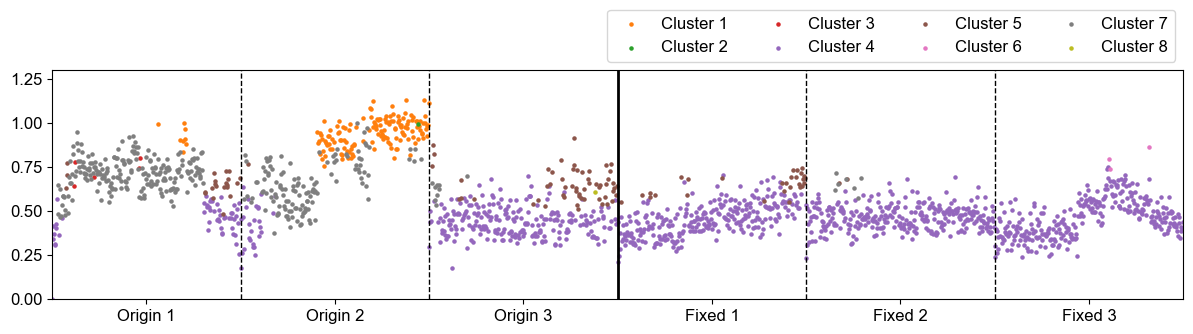

In [28]:
plt.figure(figsize=(12, 3.5))

x = np.arange(0, len(traj_merged))
y = rmsd_matrix[0, :]
for cluster_id in cluster_id_list:
    plt.scatter(x[hierarchal_cluster == cluster_id], 
                y[hierarchal_cluster == cluster_id], 
                s=5, color=plt.cm.tab10(cluster_id), label=f"Cluster {cluster_id}")


plt.xlim(0, len(traj_merged))
plt.ylim(0, 1.3)

for i in [1,2,4,5]:
    plt.axvline(i * len(traj_origin_rep1), color="k", linestyle="--", linewidth=1)
plt.axvline(3*len(traj_origin_rep1), color="k", linestyle="-", linewidth=2)


plt.xticks(np.arange(n_frames_block/2, 6*n_frames_block, n_frames_block),
              ["Origin 1", "Origin 2", "Origin 3", "Fixed 1", "Fixed 2", "Fixed 3"])

plt.legend(ncols=4, loc="lower right", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig("figure/system_1_rmsd_cluster.png", dpi=300, bbox_inches="tight")

In [9]:
c1prime_coordinates = traj_merged.xyz[:,atom_indices,:]
c1prime_coordinates_reshape = c1prime_coordinates.reshape(-1, len(atom_indices)*3)


def pairwise_distance(ca_coords):
    return pdist(ca_coords)

c1prime_pairwise_distance = np.array([pairwise_distance(c1prime_coordinates[i]) for i in range(len(traj_merged))])

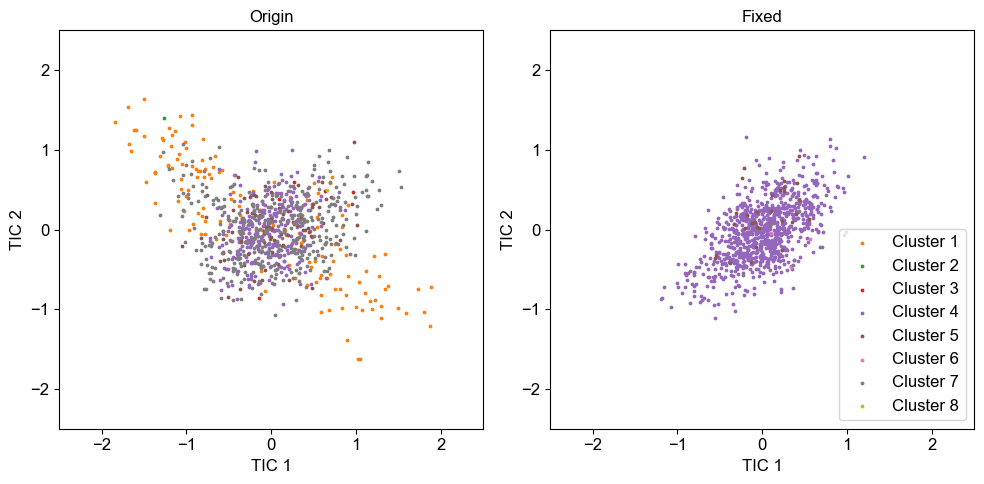

In [19]:
estimator = TICA(dim=2, lagtime=10).fit(c1prime_coordinates_reshape)
tica = estimator.fetch_model()
results_tica = tica.transform(c1prime_coordinates_reshape)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for cluster_id in cluster_id_list:
    plt.scatter(results_tica[:n_frames_block*3][hierarchal_cluster[:n_frames_block*3] == cluster_id, 0], 
                results_tica[:n_frames_block*3][hierarchal_cluster[:n_frames_block*3] == cluster_id, 1], 
                s=3, color=plt.cm.tab10(cluster_id), label=f"Cluster {cluster_id}")
plt.title("Origin", fontsize=12)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(np.arange(-2, 2.1, 1))
plt.yticks(np.arange(-2, 2.1, 1))

plt.subplot(1,2,2)
for cluster_id in cluster_id_list:
    plt.scatter(results_tica[n_frames_block*3:][hierarchal_cluster[n_frames_block*3:] == cluster_id, 0], 
                results_tica[n_frames_block*3:][hierarchal_cluster[n_frames_block*3:] == cluster_id, 1], 
                s=3, color=plt.cm.tab10(cluster_id), label=f"Cluster {cluster_id}")
plt.title("Fixed", fontsize=12)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xticks(np.arange(-2, 2.1, 1))
plt.yticks(np.arange(-2, 2.1, 1))
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("figure/system_1_tica_cacoord.png", dpi=300, bbox_inches="tight")

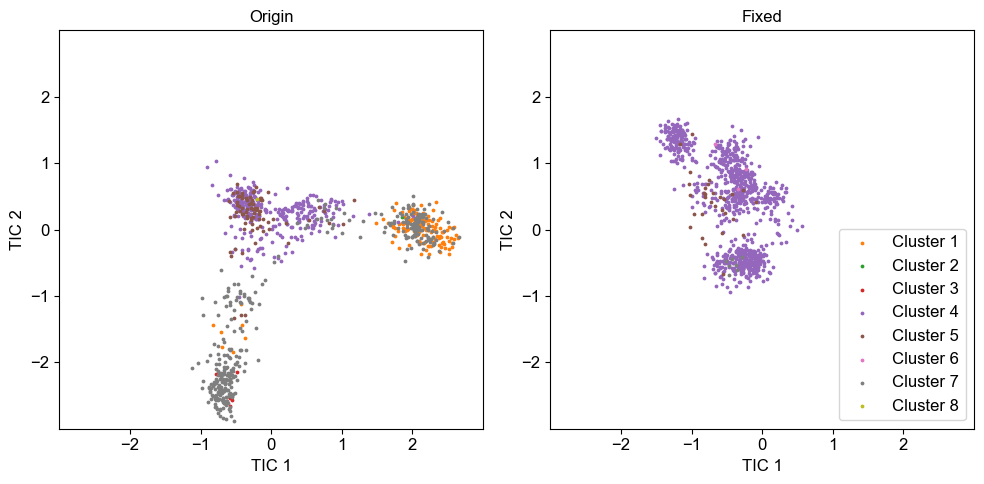

In [ ]:
estimator = TICA(dim=2, lagtime=10).fit(c1prime_pairwise_distance)
tica = estimator.fetch_model()
results_tica = tica.transform(c1prime_pairwise_distance)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for cluster_id in cluster_id_list:
    plt.scatter(results_tica[:n_frames_block*3][hierarchal_cluster[:n_frames_block*3] == cluster_id, 0], 
                results_tica[:n_frames_block*3][hierarchal_cluster[:n_frames_block*3] == cluster_id, 1], 
                s=3, color=plt.cm.tab10(cluster_id), label=f"Cluster {cluster_id}")
plt.title("Origin", fontsize=12)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-2, 2.1, 1))
plt.yticks(np.arange(-2, 2.1, 1))

plt.subplot(1,2,2)
for cluster_id in cluster_id_list:
    plt.scatter(results_tica[n_frames_block*3:][hierarchal_cluster[n_frames_block*3:] == cluster_id, 0], 
                results_tica[n_frames_block*3:][hierarchal_cluster[n_frames_block*3:] == cluster_id, 1], 
                s=3, color=plt.cm.tab10(cluster_id), label=f"Cluster {cluster_id}")
plt.title("Fixed", fontsize=12)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xticks(np.arange(-2, 2.1, 1))
plt.yticks(np.arange(-2, 2.1, 1))
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("figure/system_1_tica_pairwise.png", dpi=300, bbox_inches="tight")

In [12]:
# find centroid using rmsd matrix for each cluster

def find_centroid(cluster_id, cluster_list, rmsd_matrix):
    cluster_indices = np.where(cluster_list == cluster_id)[0]
    cluster_rmsd_matrix = rmsd_matrix[cluster_indices][:, cluster_indices]
    return cluster_indices[np.argmin(np.sum(cluster_rmsd_matrix, axis=0))]

cluster_centroids = [find_centroid(cluster_id, hierarchal_cluster, rmsd_matrix) for cluster_id in cluster_id_list]
print(cluster_centroids)

[581, 582, 139, 950, 244, 1745, 109, 864]


In [29]:
# save the centroid structures
for i, centroid in enumerate(cluster_centroids):
    traj_merged[centroid].save(f"centroid/system_1_centroid_cluster_{i+1}.pdb")